# Computergestützte Mathematik zur Analysis 

04.02.2021

Prof. Dr. Rüdiger Braun

In [1]:
from sympy import *
init_printing()
import numpy as np

# Zufallsvariable

In [2]:
from sympy.stats import *

In [3]:
X = DiscreteUniform('X', range(16))
X

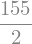

In [4]:
E(X**2)

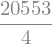

In [5]:
variance(X**2)

In [9]:
sample(X)

In [7]:
l = []
for j in range(10000):
    l.append(sample(X))

# dasselbe in numpy

In [10]:
np.random.choice(np.arange(16), 10)

array([12,  6,  3,  8, 14,  4,  5,  0,  5,  7])

In [11]:
zv = np.random.choice(np.arange(16), 10000)

Was ist der Unterschied?

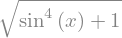

In [12]:
x = S('x')
f = sqrt(1+sin(x)**4)
f

In [13]:
fn = lambdify(x, f)  # "numpy" ist default, wenn es installiert ist

In [14]:
fn(0)

In [15]:
fn(zv)  

array([1.1524073 , 1.29754935, 1.04287665, ..., 1.399324  , 1.00304307,
       1.35850875])

Was passiert hier?

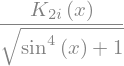

In [16]:
g = besselk(2*I, x) / f
g

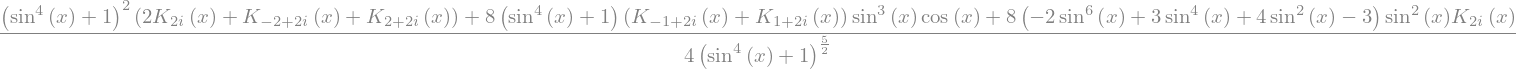

In [17]:
ddg = g.diff(x, 2).simplify()
ddg

In [18]:
ddgn = lambdify(x, ddg)

In [19]:
# ddgn(1)   # TypeError

TypeError: ufunc 'kv' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [20]:
ddgn = lambdify(x, ddg, modules=['scipy', 'numpy', 'mpmath'])

In [21]:
ddgn(1)

mpc(real='-0.1946345572600218', imag='0.0')

In [23]:
# ddgn(zv)   # TypeError

`mpmath` beherrscht keine ufuncs

# Ausgabe in anderen Programmiersprachen

Gesetzt den Fall, Sie haben eine Fortran-Bibliothek, die komplexe Besselfunktionen beherrscht:

In [24]:
print(fcode(f))

      sqrt(sin(x)**4 + 1)


In [25]:
print(fcode(ddg))

C     Not supported in Fortran:
C     besselk
C     besselk
C     besselk
C     besselk
C     besselk
      (1.0d0/4.0d0)*((sin(x)**4 + 1)**2*(2*besselk(2.0*I, x) + besselk(
     @ -2.0 + 2.0*I, x) + besselk(2.0 + 2.0*I, x)) + 8*(sin(x)**4 + 1)*(
     @ besselk(-1.0 + 2.0*I, x) + besselk(1.0 + 2.0*I, x))*sin(x)**3*cos
     @ (x) + 8*(-2*sin(x)**6 + 3*sin(x)**4 + 4*sin(x)**2 - 3)*sin(x)**2*
     @ besselk(2.0*I, x))/(sin(x)**4 + 1)**(5.0d0/2.0d0)


In [26]:
fc = fcode(ddg, user_functions={'besselk': 'my_lib_Kv'}, assign_to='res', standard=95)
print(fc)

      res = (1.0d0/4.0d0)*((sin(x)**4 + 1)**2*(2*my_lib_Kv(cmplx(0,2.0d0
     @ ), x) + my_lib_Kv(cmplx(-2.0d0,2.0d0), x) + my_lib_Kv(cmplx(2.0d0
     @ ,2.0d0), x)) + 8*(sin(x)**4 + 1)*(my_lib_Kv(cmplx(-1.0d0,2.0d0),
     @ x) + my_lib_Kv(cmplx(1.0d0,2.0d0), x))*sin(x)**3*cos(x) + 8*(-2*
     @ sin(x)**6 + 3*sin(x)**4 + 4*sin(x)**2 - 3)*sin(x)**2*my_lib_Kv(
     @ cmplx(0,2.0d0), x))/(sin(x)**4 + 1)**(5.0d0/2.0d0)


In [27]:
cc = cxxcode(ddg)
print(cc)

// Not supported in C++:
// besselk
// besselk
// besselk
// besselk
// besselk
(1.0/4.0)*(std::pow(std::pow(std::sin(x), 4) + 1, 2)*(2*besselk(2*I, x) + besselk(-2 + 2*I, x) + besselk(2 + 2*I, x)) + 8*(std::pow(std::sin(x), 4) + 1)*(besselk(-1 + 2*I, x) + besselk(1 + 2*I, x))*std::pow(std::sin(x), 3)*std::cos(x) + 8*(-2*std::pow(std::sin(x), 6) + 3*std::pow(std::sin(x), 4) + 4*std::pow(std::sin(x), 2) - 3)*std::pow(std::sin(x), 2)*besselk(2*I, x))/std::pow(std::pow(std::sin(x), 4) + 1, 5.0/2.0)


# Pattern matching 

In [28]:
x = Symbol('x')
w = Wild('w')   #  wildcard

In [29]:
pattern = sin(w)

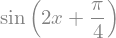

In [30]:
a = sin(2*x+pi/4)
a

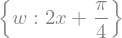

In [31]:
m = a.match(pattern)
m

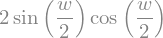

In [33]:
b = 2*sin(w/2)*cos(w/2)
b

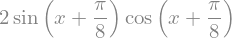

In [34]:
b.subs(m)

In [36]:
def expand_sin_x_halbe(term):
    w = Wild('w')
    pattern = sin(w)
    ersetzung = 2*sin(w/2)*cos(w/2)
    m = term.match(pattern)
    if m:
        return ersetzung.subs(m)
    else:
        return term

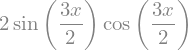

In [37]:
expand_sin_x_halbe(sin(3*x))

In [38]:
f = sin(3*x+19)
(expand_sin_x_halbe(f)-f).simplify()

In [40]:
f = 3*sin(x)
expand_sin_x_halbe(f)

In [41]:
f.func

sympy.core.mul.Mul

In [42]:
f.args

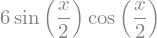

In [43]:
expand_sin_x_halbe(f.args[0]) * expand_sin_x_halbe(f.args[1])

In [44]:
def expand_sin_x_halbe(ausdr):
    ausdr = S(ausdr)
    w = Wild('w')
    pattern = sin(w)
    ersetzung = 2*sin(w/2)*cos(w/2)
    m = ausdr.match(pattern)
    if m:
        res = ersetzung.subs(m)
    elif ausdr.is_Mul:
        res = 1
        for term in ausdr.args:
            res = res * expand_sin_x_halbe(term)
    elif ausdr.is_Add:
        res = 0
        for term in ausdr.args:
            res = res + expand_sin_x_halbe(term)
    else:
        res = ausdr
    return res

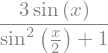

In [45]:
b = 3*sin(x)/(1+sin(x/2)**2)
b

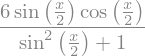

In [46]:
expand_sin_x_halbe(b)

In [47]:
x,y,z = symbols('x y z')
a = x + y + z

In [48]:
a.args

In [49]:
a.func

sympy.core.add.Add

In [50]:
a.func(*a.args)

In [51]:
def expand_sin_x_halbe(ausdr):
    ausdr = S(ausdr)
    w = Wild('w')
    pattern = sin(w)
    ersetzung = 2*sin(w/2)*cos(w/2)
    m = ausdr.match(pattern)
    if m:
        res = ersetzung.subs(m)
    else:
        try:
            f = ausdr.func
        except AttributeError:
            res = ausdr
        args = ausdr.args
        if len(args) == 0:
            res = ausdr
        else:
            liste = []
            for l in args:
                liste.append(expand_sin_x_halbe(l))
            res = f(*liste)
    return res

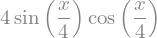

In [52]:
expand_sin_x_halbe(2*sin(x/2))

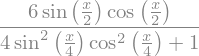

In [53]:
expand_sin_x_halbe(b)

# Zurück zu den Besselfunktionen

In [54]:
nu = S('nu')

In [55]:
f = besselj(nu, x)
g = bessely(nu, x)

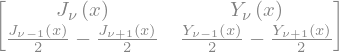

In [65]:
M = Matrix([[f,g], [f.diff(x), g.diff(x)]])
M

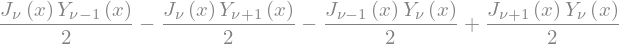

In [66]:
W = M.det().expand()
W

https://dlmf.nist.gov/10.6

In [58]:
def bessel_forward(ausdr, bessel, nu):
    w1 = Wild('w1')
    w2 = Wild('w2')
    pattern = bessel(w1, w2)
    if bessel == besselj or bessel == bessely:
        ersetzung = -bessel(nu+2, w2) + 2*(nu+1)/w2*bessel(nu+1, w2)    
    m = ausdr.match(pattern)
    if m and w1.subs(m) == nu:
        res = ersetzung.subs(m)
    else:
        try:
            f = ausdr.func
        except AttributeError:
            res = ausdr
        args = ausdr.args
        if len(args) == 0:
            res = ausdr
        else:
            liste = []
            for l in args:
                liste.append(bessel_forward(l, bessel, nu))
            res = f(*liste)
    return res

In [59]:
def bessel_backward(ausdr, bessel, nu):
    w1 = Wild('w1')
    w2 = Wild('w2')
    w3 = Wild('w3')
    pattern = bessel(w1, w2)
    if bessel == besselj or bessel == bessely:
        ersetzung = -bessel(nu-2, w2) + 2*(nu-1)/w2*bessel(nu-1, w2)            
    m = ausdr.match(pattern)
    if m and w1.subs(m) == nu:
        res = ersetzung.subs(m)
    else:
        try:
            f = ausdr.func
        except AttributeError:
            res = ausdr
        args = ausdr.args
        if len(args) == 0:
            res = ausdr
        else:
            liste = []
            for l in args:
                liste.append(bessel_backward(l, bessel, nu))
            res = f(*liste)
    return res

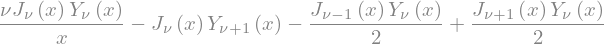

In [67]:
tmp = bessel_forward(W, bessely, nu-1).expand()
tmp

In [68]:
tmp = bessel_forward(tmp, besselj, nu-1).expand()
tmp

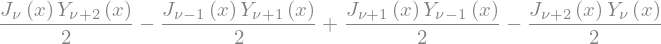

In [69]:
tmp = tmp.diff(x).expand()
tmp

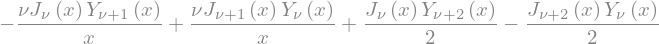

In [70]:
tmp = bessel_forward(tmp, bessely, nu-1).expand()
tmp = bessel_forward(tmp, besselj, nu-1).expand()
tmp

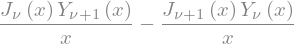

In [71]:
tmp = bessel_backward(tmp, bessely, nu+2).expand()
tmp = bessel_backward(tmp, besselj, nu+2).expand()
tmp

 Also erfüllt die Wronskische die Dgl $W'=-\frac Wx$

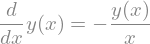

In [72]:
y = Function('y')
dgl = Eq(y(x).diff(x), -y(x)/x)
dgl

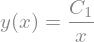

In [73]:
dsolve(dgl)